In [1]:
__imp

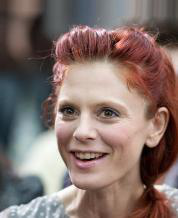

In [2]:
from PIL import Image
import numpy as np

img_ = Image.open('/sdh/data/celebA/all_imgs/000002.jpg')
img_

In [38]:
import imgaug as ia
from imgaug import augmenters as iaa


sometimes = lambda aug: iaa.Sometimes(0.4, aug)
often = lambda aug: iaa.Sometimes(0.8, aug)

# seq = iaa.Sequential([
    
#     iaa.Fliplr(0.5),  # horizontally flip 50% of the images
#     often(iaa.Affine(
#         # scale images to 80-120% of their size, individually per axis
#         scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
#         # translate by -20 to +20 percent (per axis)
#         translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
#         rotate=(-8, 8),  # rotate by -45 to +45 degrees
#         shear=(-5, 5),  # shear by -16 to +16 degrees
#         order=[3],  # use nearest neighbour or bilinear interpolation (fast)
#         cval=(0),  # if mode is constant, use a cval between 0 and 255
#         # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#         mode='constant', 
#     )),
#     sometimes(iaa.Add((-8, 8))), # change brightness of images (by -10 to 10 of original value)
#     sometimes(iaa.AddToHueAndSaturation((-8, 8))), # change hue and saturation
#     sometimes(iaa.PiecewiseAffine(scale=(0.00, 0.02), order=3)),
#     sometimes(iaa.ContrastNormalization((0.5, 1.5))),
#     often(iaa.GaussianBlur(sigma=(0, 0.3))),  # blur images with a sigma of 0 to 3.0
# #     (iaa.ElasticTransformation(alpha=(0.0, 1.5), sigma=(9.0, 10))),
    
# ])


seq = iaa.Sequential([
    
    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    often(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
    often(iaa.Affine(
            scale={"x": (0.85, 1.15), "y": (0.85, 1.15)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-25, 25), # rotate by -45 to +45 degrees
            shear=(-12, 12), # shear by -16 to +16 degrees
            order=[0, 1, 3], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL, # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            backend='cv2'
        )),
    sometimes(iaa.Add((-10, 10))), # change brightness of images (by -10 to 10 of original value)
    sometimes(iaa.AddToHueAndSaturation((-10, 8))), # change hue and saturation
#         (iaa.PiecewiseAffine(scale=(0.00, 0.02), order=3)),
    sometimes(iaa.ContrastNormalization((0.5, 1.5))),
    sometimes(iaa.GaussianBlur(sigma=(0, 0.7))),  # blur images with a sigma of 0 to 3.0
#         (iaa.ElasticTransformation(alpha=(0.0, 1.5), sigma=(9.0, 10))),
])


In [23]:
seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
#         iaa.SomeOf((0, 5),
#             [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                (iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                (iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                (iaa.PerspectiveTransform(scale=(0.01, 0.1)))
#             ],
#             random_order=True
#         )
    ],
    random_order=True
)


In [4]:
iaa.Affine??

In [34]:
ia.__version__

'0.2.5'

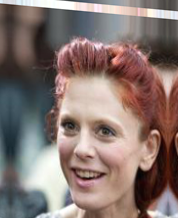

In [41]:
Image.fromarray(seq.augment_image(np.array(img_)))

In [36]:
img__ = np.array(img_)
seq.augment_image(img__);

In [37]:
%timeit seq.augment_image(img__)

4.61 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit seq.augment_image(img__)

770 µs ± 5.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
b
